<a href="https://colab.research.google.com/github/rishis123/HealthTrendsCode/blob/main/negative_binomial_andXGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#First -- starting off with negative binomial regression. Just checking the results compared to ARIMA and Prophet.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tsa.stattools import adfuller
from patsy import dmatrices
import itertools


from statsmodels.formula.api import glm

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt




In [ ]:
file_path = '/content/HospitalNYS.csv'
df_hospital = pd.read_csv(file_path)
df_hospital = df_hospital.rename(columns={"As of Date": "ds", "Facility County": "County"})
print(df_hospital.tail())
print(df_hospital.shape)


                ds    County  Patients Currently Hospitalized  \
259804  03/26/2020     YATES                                0   
259805  03/26/2020  SCHUYLER                                0   
259806  03/26/2020   STEUBEN                                0   
259807  03/26/2020   STEUBEN                                0   
259808  03/26/2020  ONONDAGA                                6   

        Patients Admitted Due to COVID  Patients Admitted Not Due to COVID  
259804                               0                                   0  
259805                               0                                   0  
259806                               0                                   0  
259807                               0                                   0  
259808                               0                                   0  
(259809, 5)


In [ ]:
df_hospital['ds'] = pd.to_datetime(df_hospital['ds'], format='%m/%d/%Y') #convert to datetime fromat

df_hospital = df_hospital.groupby(['ds', 'County']).sum().reset_index() #We add all other values for columns that share values
df_hospital = df_hospital.drop_duplicates(subset=['ds', 'County']) #drop duplicates
df_hospital = df_hospital.sort_values(by=['ds']).reset_index(drop=True)
print(df_hospital)
print(df_hospital.shape)


              ds      County  Patients Currently Hospitalized  \
0     2020-03-26      ALBANY                               22   
1     2020-03-26    ONONDAGA                               19   
2     2020-03-26     ONTARIO                                3   
3     2020-03-26      ORANGE                               62   
4     2020-03-26     ORLEANS                                1   
...          ...         ...                              ...   
74551 2024-06-24  LIVINGSTON                                0   
74552 2024-06-24     MADISON                                1   
74553 2024-06-24      MONROE                               79   
74554 2024-06-24    DELAWARE                                0   
74555 2024-06-24       YATES                                0   

       Patients Admitted Due to COVID  Patients Admitted Not Due to COVID  
0                                   0                                   0  
1                                   0                              

In [ ]:
counties = df_hospital['County'].unique()
print(counties)

['ALBANY' 'ONONDAGA' 'ONTARIO' 'ORANGE' 'ORLEANS' 'OSWEGO' 'OTSEGO'
 'PUTNAM' 'QUEENS' 'RENSSELAER' 'RICHMOND' 'ROCKLAND' 'SCHENECTADY'
 'SCHOHARIE' 'SCHUYLER' 'ST. LAWRENCE' 'STEUBEN' 'SUFFOLK' 'SULLIVAN'
 'TOMPKINS' 'ULSTER' 'WARREN' 'WAYNE' 'WESTCHESTER' 'WYOMING' 'YATES'
 'ONEIDA' 'NIAGARA' 'SARATOGA' 'NASSAU' 'NEW YORK' 'BRONX' 'BROOME'
 'CATTARAUGUS' 'CAYUGA' 'CHAUTAUQUA' 'CHEMUNG' 'CHENANGO' 'CLINTON'
 'COLUMBIA' 'CORTLAND' 'DELAWARE' 'DUTCHESS' 'ALLEGANY' 'MONTGOMERY'
 'ERIE' 'MONROE' 'MADISON' 'LIVINGSTON' 'KINGS' 'LEWIS' 'HERKIMER'
 'GENESEE' 'FULTON' 'FRANKLIN' 'ESSEX' 'JEFFERSON']


As a test, let's just do it in the county of Albany.

In [ ]:
data = df_hospital[df_hospital['County'] == "ALBANY"]
#Adding features for these time data rather than viewing time-series wise.
data['MONTH'] = data['ds'].dt.month
data['DAY_OF_WEEK'] = data['ds'].dt.dayofweek
data['DAY'] = data['ds'].dt.day

print(data.tail(20))
print(data.shape)

              ds  County  Patients Currently Hospitalized  \
73459 2024-05-24  ALBANY                                8   
73503 2024-05-28  ALBANY                                4   
73560 2024-05-29  ALBANY                                3   
73618 2024-05-30  ALBANY                                5   
73687 2024-05-31  ALBANY                                6   
73744 2024-06-03  ALBANY                                7   
73788 2024-06-04  ALBANY                                6   
73845 2024-06-05  ALBANY                                5   
73903 2024-06-06  ALBANY                                6   
73959 2024-06-07  ALBANY                                9   
74029 2024-06-10  ALBANY                               10   
74073 2024-06-11  ALBANY                                9   
74130 2024-06-12  ALBANY                                7   
74188 2024-06-13  ALBANY                               11   
74244 2024-06-14  ALBANY                               11   
74301 2024-06-17  ALBANY

<ipython-input-6-e783ef1615ac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MONTH'] = data['ds'].dt.month
<ipython-input-6-e783ef1615ac>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DAY_OF_WEEK'] = data['ds'].dt.dayofweek
<ipython-input-6-e783ef1615ac>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [ ]:
# Create lagged features for 'Patients Currently Hospitalized' (want to predict based on past values)
for lag in range(1, 5):  # Lag from 1 week up to 4 weeks (remember each timestep is just 1 day)
    data[f'Lag_{lag}'] = data['Patients Currently Hospitalized'].shift(7 * lag)

<ipython-input-8-c51caa846558>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lag_{lag}'] = data['Patients Currently Hospitalized'].shift(7 * lag)
<ipython-input-8-c51caa846558>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lag_{lag}'] = data['Patients Currently Hospitalized'].shift(7 * lag)
<ipython-input-8-c51caa846558>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [ ]:
data.dropna(inplace=True) #there will be starting rows that are N/A - remove them
print(data)

              ds  County  Patients Currently Hospitalized  \
1626  2020-04-23  ALBANY                               79   
1684  2020-04-24  ALBANY                               83   
1740  2020-04-25  ALBANY                               85   
1810  2020-04-26  ALBANY                               89   
1854  2020-04-27  ALBANY                               92   
...          ...     ...                              ...   
74301 2024-06-17  ALBANY                               14   
74359 2024-06-18  ALBANY                               16   
74415 2024-06-20  ALBANY                               11   
74473 2024-06-21  ALBANY                               13   
74529 2024-06-24  ALBANY                               10   

       Patients Admitted Due to COVID  Patients Admitted Not Due to COVID  \
1626                                0                                   0   
1684                                0                                   0   
1740                                

<ipython-input-10-f15c1dc19070>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True) #there will be starting rows that are N/A - remove them


In [ ]:
#create the training and testing data sets
mask = np.random.rand(len(data)) < 0.8
df_train = data[mask]
df_test = data[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=1017
Testing data set length=263


In [ ]:
#Setup the regression expression in patsy notation. All features we consider using on right (need Q on left because there are spaces in the name)
expr = """Q('Patients Currently Hospitalized') ~ ds + MONTH + DAY_OF_WEEK + DAY + Lag_1 + Lag_2 + Lag_3 + Lag_4"""
#Set up the X and y matrices for the training and testing data sets
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [ ]:
#Using the statsmodels GLM class, train the Poisson regression model on the training data set
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
#print out the training summary
print(poisson_training_results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


                          Generalized Linear Model Regression Results                           
Dep. Variable:     Q('Patients Currently Hospitalized')   No. Observations:                 1017
Model:                                              GLM   Df Residuals:                        0
Model Family:                                   Poisson   Df Model:                         1016
Link Function:                                      Log   Scale:                          1.0000
Method:                                            IRLS   Log-Likelihood:                -2835.1
Date:                                  Tue, 23 Jul 2024   Deviance:                   2.7289e-13
Time:                                          15:14:13   Pearson chi2:                 1.92e-20
No. Iterations:                                       7   Pseudo R-squ. (CS):              1.000
Covariance Type:                              nonrobust                                         
                              

Focus on mu value per https://timeseriesreasoning.com/contents/negative-binomial-regression-model/

Mu or fitted Rates (explanation from ChatGPT)

1. Understanding the Model's Predictions
The fitted rates represent the model's predictions for the dependent variable based on the independent variables and their coefficients. This helps in understanding how well the model captures the underlying patterns in the data.

2. Model Evaluation
By comparing the fitted values (mu) to the actual observed values, you can assess the accuracy and performance of your model. Common evaluation metrics like Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared are derived from this comparison.

In [ ]:
#print out the fitted rate vector
print(poisson_training_results.mu)
#Add the λ vector as a new column called 'BB_LAMBDA' to the Data Frame of the training data set
df_train['COUNT_LAMBDA'] = poisson_training_results.mu

[79. 83. 85. ... 14. 16. 13.]


In [ ]:
df_train = df_train.drop(columns=['Count_LAMBDA'])
print(df_train) #added correctly

              ds  County  Patients Currently Hospitalized  \
1626  2020-04-23  ALBANY                               79   
1684  2020-04-24  ALBANY                               83   
1740  2020-04-25  ALBANY                               85   
1810  2020-04-26  ALBANY                               89   
1854  2020-04-27  ALBANY                               92   
...          ...     ...                              ...   
74188 2024-06-13  ALBANY                               11   
74244 2024-06-14  ALBANY                               11   
74301 2024-06-17  ALBANY                               14   
74359 2024-06-18  ALBANY                               16   
74473 2024-06-21  ALBANY                               13   

       Patients Admitted Due to COVID  Patients Admitted Not Due to COVID  \
1626                                0                                   0   
1684                                0                                   0   
1740                                

Again:

Poisson Regression has poisson regression (mean = variance)

Auxiliary OLS regression used as an intermediate model to handle overdispersion

Negative Binomial Regression good for overdispersion afterwards.

In [ ]:
import statsmodels.formula.api as smf
#Now, having done Poisson, we use the mu values to run an OLS regression, and finally Negative Binomial (more precise results by building off previous)


#add a derived column called 'AUX_OLS_DEP' to the pandas Data Frame. This new column will store the values of the dependent variable of the OLS regression
df_train['AUX_OLS_DEP'] = df_train.apply(
    lambda x: ((x['Patients Currently Hospitalized'] - x['COUNT_LAMBDA'])**2 - x['COUNT_LAMBDA']) / x['COUNT_LAMBDA'],
    axis=1 #Calculated here by comparing squared residuals to fitted values (count_lambda)
)

In [ ]:
print(df_train) #Contains AUX_OLS_DEP -- output of the intermediary OLS regression

              ds  County  Patients Currently Hospitalized  \
1626  2020-04-23  ALBANY                               79   
1684  2020-04-24  ALBANY                               83   
1740  2020-04-25  ALBANY                               85   
1810  2020-04-26  ALBANY                               89   
1854  2020-04-27  ALBANY                               92   
...          ...     ...                              ...   
74188 2024-06-13  ALBANY                               11   
74244 2024-06-14  ALBANY                               11   
74301 2024-06-17  ALBANY                               14   
74359 2024-06-18  ALBANY                               16   
74473 2024-06-21  ALBANY                               13   

       Patients Admitted Due to COVID  Patients Admitted Not Due to COVID  \
1626                                0                                   0   
1684                                0                                   0   
1740                                

In [ ]:
#use patsy to form the model specification for the OLSR
#-1 so no regression intercept, just fitted through origin
ols_expr = """AUX_OLS_DEP ~ COUNT_LAMBDA - 1"""

#Configure and fit the OLSR model
aux_olsr_results = smf.ols(ols_expr, df_train).fit()

In [ ]:

#Print the regression params
print(aux_olsr_results.params)



COUNT_LAMBDA   -0.009292
dtype: float64


This is alpha coefficient -- we get -0.009292. Negative Binomial Regression formula is

Variance = mean + alpha * mean ^ 2, so we need to check if statistically significant alpha -- otherwise can just use 0 and then becomes variance = mean (or poisson distribution).



In [ ]:
#Find t-value
aux_olsr_results.tvalues

#Using calculator, with 1017 as #observations from df_train and t-value of -35.67, this alpha value is stat. significant -- this is not poisson.

COUNT_LAMBDA   -35.668873
dtype: float64

In [ ]:
print(X_train)

       Intercept  ds[T.Timestamp('2020-04-24 00:00:00')]  \
1626         1.0                                     0.0   
1684         1.0                                     1.0   
1740         1.0                                     0.0   
1810         1.0                                     0.0   
1854         1.0                                     0.0   
...          ...                                     ...   
74188        1.0                                     0.0   
74244        1.0                                     0.0   
74301        1.0                                     0.0   
74359        1.0                                     0.0   
74473        1.0                                     0.0   

       ds[T.Timestamp('2020-04-25 00:00:00')]  \
1626                                      0.0   
1684                                      0.0   
1740                                      1.0   
1810                                      0.0   
1854                              

In [ ]:
#Given confirmed overdispersion, we finally do Negative Binomial

#train the NB2 model on the training data set
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


ValueError: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.

In [ ]:
def train_and_evaluate(data, forecast_horizon):
    all_predictions = []
    all_actuals = []
    all_dates = []  # To store dates corresponding to the forecasts

    for start in range(len(data) - forecast_horizon):
        train_end = start + forecast_horizon

        # Training and testing data
        train_data = data.iloc[:train_end]
        test_data = data.iloc[train_end:train_end + forecast_horizon]

        import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def train_and_evaluate(data, forecast_horizon):
    all_predictions = []
    all_actuals = []
    all_dates = []

    for start in range(len(data) - forecast_horizon):
        train_end = start + forecast_horizon

        # Training and testing data
        train_data = data.iloc[:train_end]
        test_data = data.iloc[train_end:train_end + forecast_horizon]

        # Prepare endog and exog for training -- detailed (https://www.statsmodels.org/stable/glm.html)

        #Dependent var
        endog = train_data['Patients Currently Hospitalized']

        #Independent Var
        exog = np.arange(len(train_data)).reshape(-1, 1)
        exog = sm.add_constant(exog)  # Add a constant (intercept term)
        #exog ends up as a dataframe containing a constant 1 as a intercept, and the timestamp.

        # Fit the model
        print(endog)
        print(exog)
        model = sm.GLM(endog, exog, family=sm.families.NegativeBinomial())
        fit = model.fit()

        # Prepare exog for the test period
        exog_test = np.arange(len(train_data), len(train_data) + forecast_horizon).reshape(-1, 1)
        exog_test = sm.add_constant(exog_test)

        print('made it here')

        # Make predictions
        predictions = fit.predict(exog_test)

        # Store predictions and actuals
        all_predictions.extend(predictions)
        all_actuals.extend(test_data['Patients Currently Hospitalized'])
        all_dates.extend(test_data['ds'])

    # Convert lists to DataFrames
    forecast_df = pd.DataFrame({
        'ds': all_dates,
        'forecast': all_predictions
    })

    actual_df = data[['ds', 'Patients Currently Hospitalized']]
    # Calculate metrics
    mae = mean_absolute_error(all_actuals, all_predictions)
    r2 = r2_score(all_actuals, all_predictions)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(actual_df['ds'], actual_df['Patients Currently Hospitalized'], label='Actual', color='blue')
    plt.plot(forecast_df['ds'], forecast_df['forecast'], label='Forecast', color='red', linestyle='--')

    plt.title(f'Forecast vs Actual Hospitalizations (Horizon: {forecast_horizon} Weeks)')
    plt.xlabel('Date')
    plt.ylabel('Patients Currently Hospitalized')
    plt.legend(title=f'MAE: {mae:.2f}, R²: {r2:.2f}')
    plt.grid(True)
    plt.show()

    return mae, r2

In [ ]:
forecast_horizons = [1, 2, 3, 4, 5, 6]

results = {}
for horizon in forecast_horizons:
    #We are just doing this in the county of Albany for now.
    mae, r2 = train_and_evaluate(data, horizon)
    results[horizon] = {'MAE': mae, 'R^2': r2}

print(results)

0    46
Name: Patients Currently Hospitalized, dtype: int64
[[1. 0.]]
made it here


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


ValueError: shapes (1,1) and (2,) not aligned: 1 (dim 1) != 2 (dim 0)

ValueError: shapes (1,1) and (2,) not aligned: 1 (dim 1) != 2 (dim 0)
 -- Fix, consider what Negative Binomial code here does diferently: https://timeseriesreasoning.com/contents/negative-binomial-regression-model/.

 Create derived regressors for X matrix:

df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day

#Moving on to XGBOOST

https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

In [ ]:
import xgboost
from xgboost import XGBRegressor


In [ ]:
#Let's deal only with data, the df of Albany
model = XGBRegressor()


In [ ]:
data = data.drop(columns=['County', 'Patients Admitted Due to COVID', 'Patients Admitted Not Due to COVID'])
data = data.rename(columns={"Patients Currently Hospitalized": "Count"})


Restructure to supervised time-series problem by dropping time-column, and making the question of predicting next time-stamp value, per above website.

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Transform a time series dataset into a supervised learning dataset.

    Parameters:
    - data: A DataFrame containing 'Count' and 'ds' columns.
    - n_in: Number of lag observations as input (X). That is, how many past time-steps we look at (just past 1 for now).
    - n_out: Number of observations as output (y). That is, how many future time-steps we look at (just future 1 for now).
    - dropnan: Boolean whether or not to drop rows with NaN values.

    Returns:
    - A DataFrame transformed into a supervised learning dataset.
    """
    # Create a DataFrame for the output (will have Count-1, Count, and ds columns)
    df = data.copy()
    cols = list() #becomes a list of dataframe, will first contain Count(t-1) then Count(t), from both loops below.

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        # Shift the 'Count' column by i steps backward
        df_shifted = df[['Count']].shift(i)
        # Rename the column to indicate the time step
        df_shifted.columns = [f'Count(t-{i})']
        # Add the shifted DataFrame to the list of columns
        cols.append(df_shifted)

    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        # Shift the 'Count' column by i steps forward
        df_shifted = df[['Count']].shift(-i)
        # Rename the column to indicate the time step
        if i == 0:
            df_shifted.columns = [f'Count(t)']
        else:
            df_shifted.columns = [f'Count(t+{i})']
        # Add the shifted DataFrame to the list of columns
        cols.append(df_shifted)

    # Concatenate all columns along with the original 'ds' column
    agg = pd.concat(cols, axis=1)
    agg['ds'] = data['ds']

    # Drop rows with NaN values if specified
    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [ ]:
def train_test_split(data, n_test):
    #modified version for dataframe
    data = np.asarray(data)
    train = data[:-n_test, :]  # Training set: all rows except the last n_test rows
    test = data[-n_test:, :]   # Test set: the last n_test rows
    return train, test


In [ ]:
best_params = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
#See bottom

In [ ]:
from numpy import asarray

#Outputs predictions for testX, having trained on the current set.
def xgboost_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns

    #X trained on Count(t-1) and y trained on Count(t)
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model -- seeks smallest sum of squared error.

    #1000 trees -- high intricacy capturing, potentially overfitting
    model = XGBRegressor(objective='reg:squarederror', learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    subsample=best_params['subsample'])

    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(asarray([testX]))
    return yhat[0]

In [ ]:
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset (Slide window forward -- adding new data to training set)
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX) #functino defined above
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        # print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    r2 = r2_score(test[:, -1], predictions)
    return error, r2, test[:, -1], predictions

MAE for 1 weeks: 1.838
R^2 for 1 weeks: 0.324
MAE for 2 weeks: 1.889
R^2 for 2 weeks: 0.334
MAE for 3 weeks: 2.147
R^2 for 3 weeks: 0.196
MAE for 4 weeks: 2.148
R^2 for 4 weeks: 0.186


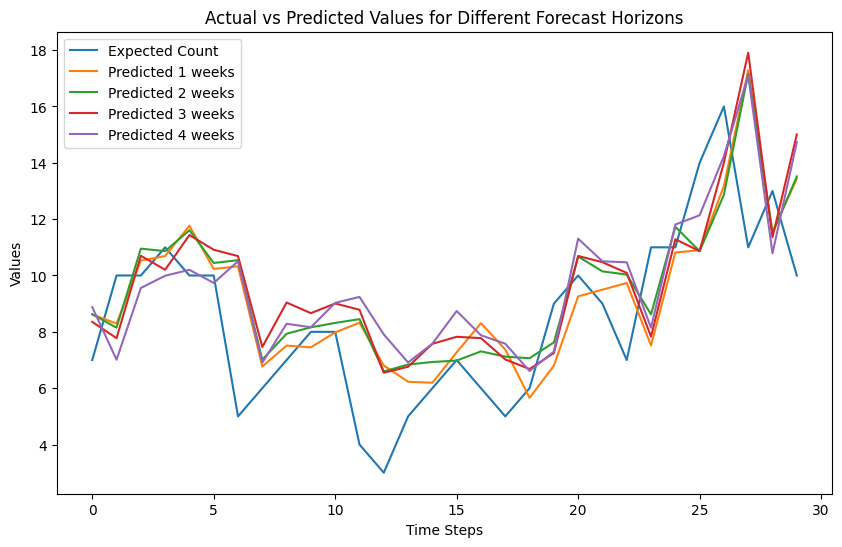

In [ ]:
# Initialize the plot
plt.figure(figsize=(10, 6))

# Loop through different forecast horizons
for n in range(1, 5): # Predict 1 to 4 weeks
    data_supervised = series_to_supervised(data, n_in=30, n_out=7*n, dropnan=True)
    data_supervised = data_supervised.drop(columns=['ds'])
    data_supervised = data_supervised.to_numpy()

    mae, r2, y, yhat = walk_forward_validation(data_supervised, 30)
    print('MAE for ' + str(n) + ' weeks: %.3f' % mae)
    print('R^2 for ' + str(n) + ' weeks: %.3f' % r2)


    if n == 1:
        #Plot expected only once
        plt.plot(y, label=f'Expected Count')

    plt.plot(yhat, label=f'Predicted {n} weeks')

# Add legend, labels, and title
plt.legend()
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values for Different Forecast Horizons')
plt.show()

Below: Trying to find ideal number of boosting rounds (above is 1000, aka 1000 simple trees).

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 500, 1000, 1500], # num of boosting rounds or trees
    'learning_rate': [0.01, 0.1, 0.2], # how much new trees should be weighted (inversely proportional to number of trees that should be used)
    'max_depth': [3, 5, 7], #how deep/intricate each individual tree is
    'subsample': [0.6, 0.8, 1.0] #what fraction of total training data is used -- help prevent overfitting
}

# Initialize the model
model = XGBRegressor(objective='reg:squarederror')

# Initialize GridSearchCV - 5 fold cross-validation.
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)

# Prepare the data
data_supervised = series_to_supervised(data, n_in=30, n_out=7, dropnan=True)
data_supervised = data_supervised.drop(columns=['ds'])
data_supervised = data_supervised.to_numpy()

# Split the data into input and output columns
X, y = data_supervised[:, :-1], data_supervised[:, -1]

# Perform grid search
grid_search.fit(X, y)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best MAE score: ", -grid_search.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best MAE score:  4.304894628775088


Best parameters found:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best MAE score:  4.304894628775088